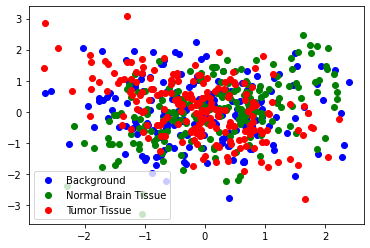

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#load data 
data = pd.read_csv('Image2.csv', header=None)

#split data
bg_data = data.iloc[:200, :]
normal_data = data.iloc[200:400, :]
tumor_data = data.iloc[400:, :]

plt.scatter(bg_data[0], bg_data[1], color='blue', label='Background')
plt.scatter(normal_data[0], normal_data[1], color='green', label='Normal Brain Tissue')
plt.scatter(tumor_data[0], tumor_data[1], color='red', label='Tumor Tissue')
plt.legend()
plt.show()

In [4]:
import numpy as np

def E_step(data, means):
    R = np.zeros((3, 600))
    for i in range(600):
        #euclidean distance
        distances = [np.linalg.norm(data.iloc[i,:] - means[j]) for j in range(3)]
        #find the index of the mean with the smallest distance
        min_idx = np.argmin(distances)
        #assigning
        R[min_idx, i] = 1
        
    return R

means = np.array([[0,0], [4, 3], [-2, 4]])
covs = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
weights = np.array([0.3, 0.4, 0.3])

R = E_step(data, means)

print(R[:, :50])


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]]


In [5]:
def M_step(data, R):
    new_means = np.zeros((3, 2))
    new_covs = np.zeros((3, 2, 2))
    
    for k in range(3):
        Nk = np.sum(R[k,:])
        
        #update the mean
        new_means[k] = (1/Nk) * np.sum(R[k,:].reshape(1,-1) * data.values.T, axis=1)
        
        #update the covariance
        new_covs[k] = (1/Nk) * np.dot((R[k,:].reshape(1,-1) * (data.values - new_means[k]).T), (data.values - new_means[k]))
        
    return new_means, new_covs

new_means, new_covs = M_step(data, R)

print('Updated Means:')
print(new_means)
print('\nUpdated Covariances:')
print(new_covs)


Updated Means:
[[-0.01487545 -0.00685517]
 [ 1.86129727  2.00036125]
 [-1.9766022   2.07971658]]

Updated Covariances:
[[[ 0.89197566  0.00889288]
  [ 0.00889288  0.84081304]]

 [[ 0.03454337 -0.05185701]
  [-0.05185701  0.12077032]]

 [[ 0.26091642  0.04990456]
  [ 0.04990456  0.26473843]]]


converged in step : 14
Final Means:
[[-0.26849419 -0.92604895]
 [ 0.90646733  0.36807678]
 [-0.84263741  0.75906057]]

Final Covariances:
[[[ 0.53189564 -0.06893279]
  [-0.06893279  0.34537548]]

 [[ 0.36150855  0.01552642]
  [ 0.01552642  0.49135215]]

 [[ 0.41415562 -0.0223189 ]
  [-0.0223189   0.4009015 ]]]


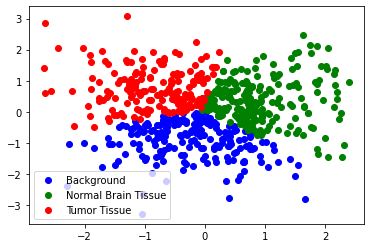

In [11]:
from scipy.stats import multivariate_normal

def EM_algorithm(data, means, covs, max_iter=100, tol=1e-4):
    
    ll_old = -np.inf
    
    R = np.zeros((3, 600))
    
    for i in range(max_iter):
        
        R = E_step(data, means)
        
        means, covs = M_step(data, R)
        
        #calculate the log-likelihood of the observed data
        ll_new = 0
        for n in range(600):
            ll_new += np.log(np.sum([weights[k] * multivariate_normal.pdf(data.iloc[n,:], mean=means[k], cov=covs[k]) for k in range(3)]))
        
        #check for convergence
        if np.abs(ll_new - ll_old) < tol:
            print("converged in step :" , i)
            break
        
        #update the log-likelihood
        ll_old = ll_new
        
    return means, covs


final_means, final_covs = EM_algorithm(data, means, covs)

print('Final Means:')
print(final_means)
print('\nFinal Covariances:')
print(final_covs)

R = E_step(data, final_means)
plt.scatter(data.values[:,0][R[0,:]==1], data.values[:,1][R[0,:]==1], color='blue', label='Background')
plt.scatter(data.values[:,0][R[1,:]==1], data.values[:,1][R[1,:]==1], color='green', label='Normal Brain Tissue')
plt.scatter(data.values[:,0][R[2,:]==1], data.values[:,1][R[2,:]==1], color='red', label='Tumor Tissue')
plt.legend()
plt.show()